# Set up model and hyperparameters

In [1]:
from models.WaveNetVAE.WaveVae import WaveNetVAE

import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

"""
Hyperparameters
"""

batchsize = 8
device=['cuda:3', 'cuda:4']
input_size = (60, 112)
upsamples = [2, 2, 2, 2, 2, 2, 2, 2]
zsize = 32

WaveVAE = WaveNetVAE(input_size,
                     num_hiddens = 768,
                     upsamples = upsamples,
                     zsize = zsize,
                    out_channels = 256,
                    devices = device)



WaveNet Receptive Field:  4093


## Load datasets

In [2]:
from models.WaveNetVAE.WVData import WVDataset

VAEDataset = WVDataset(audio_path = "./dataset/LJSpeech-1.1/wavs",
                       length = 4096,
                       skip_size = 4096 // 2,
                       sample_rate = 16000,
                       max_files = 2000,
                       win_length = 400)

val_VAEDataset = WVDataset(audio_path = "./dataset/val",
                       length = 4096,
                       skip_size = 4096 // 2,
                       sample_rate = 16000,
                       max_files = 32,
                       win_length = 400)

VAEDataloader = DataLoader(VAEDataset,
                           batch_size = batchsize,
                           shuffle = True)

val_VAEDataloader = DataLoader(val_VAEDataset,
                           batch_size = batchsize,
                           shuffle = False)

Loading and preprocessing files to dataset.:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Loading and preprocessing files to dataset.:   0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

# Test tensor

Trying tensors with sizes:
Onehot size:  torch.Size([8, 4096]) | MFCC size:  torch.Size([8, 60, 33]) | Target size:  torch.Size([8, 4097])


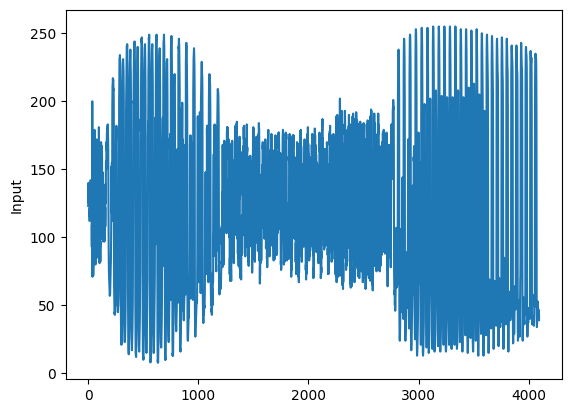

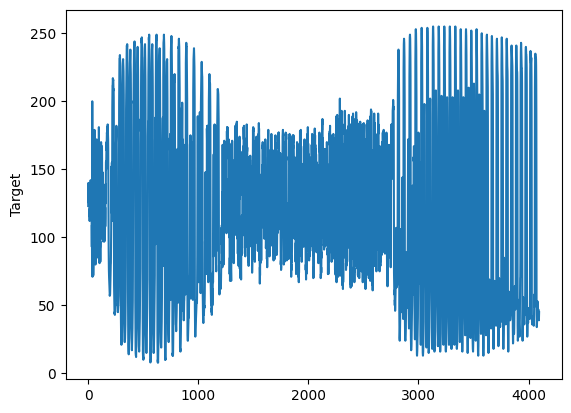

Target value:  45  | Input Value:  42
torch.Size([8, 4097])
Before downsample:  torch.Size([8, 768, 33])
After downsample:  torch.Size([8, 768, 16])
X size before wavenet:  torch.Size([8, 4096])
Condition before upsampling:  torch.Size([8, 768, 16])
Condition and x after c upsampling:  torch.Size([8, 768, 4096]) torch.Size([8, 4096])
Tensors passed through model succesfully torch.Size([8, 4096, 256])
torch.Size([1, 256]) torch.Size([1])
tensor(162, device='cuda:3') 45 42
tensor([-0.0020, -0.0968, -0.1729,  0.2724, -0.2568,  0.0878, -0.0229,  0.2752,
        -0.1962, -0.1538,  0.1673, -0.1685, -0.0371, -0.1549,  0.1627, -0.4809,
         0.0344,  0.2257, -0.0929,  0.1199, -0.1761, -0.0846, -0.0550,  0.1291,
         0.0431, -0.0858,  0.3164, -0.2819, -0.2056, -0.0371,  0.2399, -0.2150,
        -0.1166,  0.0451, -0.0768, -0.1094,  0.0375,  0.1356,  0.2701, -0.1427,
        -0.2932, -0.1851,  0.3384,  0.2440, -0.2125,  0.0300, -0.1712, -0.0200,
         0.1465, -0.1529, -0.2589,  0.4540, 

IndexError: too many indices for tensor of dimension 1

In [3]:
import torchaudio
import matplotlib.pyplot as plt

# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

onehot, mfcc, target, oht = next(iter(val_VAEDataloader))
onehot = onehot.to(device[0])
mfcc = mfcc.to(device[0])
target = target.to(device[0])

print("Trying tensors with sizes:")
print("Onehot size: ", onehot.size(), "| MFCC size: ", mfcc.size(), "| Target size: ", target.size())

plt.plot(torch.squeeze(onehot[0]).cpu().numpy())
plt.ylabel('Input')
plt.show()

plt.plot(torch.squeeze(target[0]).cpu().numpy())
plt.ylabel('Target')
plt.show()



print("Target value: ", target[0, -1].item(), " | Input Value: ", onehot[0, -1].item())

# target = torch.unsqueeze(torch.unsqueeze(target[:, -1], 1), 1)
print(target.size())

output, _, _ = WaveVAE(onehot, mfcc, False, True)
output = output.transpose(2,1)
print("Tensors passed through model succesfully", output.size())

# reconstruction_loss = torch.mean(loss_fn(torch.squeeze(output), torch.squeeze(target)[:, 1:])[-1], 0)

print(output[0, 4095:].size(), target[0, 4096:].contiguous().view(-1).size())
print(torch.argmax(output[0, 4095:].squeeze()), target[0, -1].squeeze().item(), onehot[0, -1].squeeze().item())
print(output[0, -1].cpu())

reconstruction_loss = loss_fn(output[0, -1] * 100, target[0, -1])
print("Reconstruction loss =", reconstruction_loss.item())

print('OHT Size: ', oht.size())

print(oht[0, -1])
print(target[0, -1])
reconstruction_loss = loss_fn(oht[0, -1].type(torch.FloatTensor).to(device) * 10, target[0, -1])
print("Reconstruction loss =", reconstruction_loss.item())

# onehot = torch.nn.functional.sigmoid(onehot[0, :, -1])
# output = torch.nn.functional.sigmoid(output[0, :, -1])
# onehotmax = torch.argmax(onehot)
# outputmax = torch.argmax(output)




# Start training

In [ ]:
from models.WaveNetVAE.train import train
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")
writer = SummaryWriter()

train(WaveVAE, VAEDataloader, val_VAEDataloader,
      writer = writer,
      learning_rate = 0.0001,
      epoch_amount = 100,
      logs_per_epoch = 20,
      kl_anneal = 0.01,
      max_kl = 0.5,
      device = device[0],
     export_path = './exports')


Training. Epoch: 0. Loss for step 1: n.v.t.:   0%|          | 0/11026 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Training. Epoch: 1. Loss for step 1: n.v.t.:   0%|          | 0/11026 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Training. Epoch: 2. Loss for step 1: n.v.t.:   0%|          | 0/11026 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Training. Epoch: 3. Loss for step 1: n.v.t.:   0%|          | 0/11026 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Training. Epoch: 4. Loss for step 1: n.v.t.:   0%|          | 0/11026 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Training. Epoch: 5. Loss for step 1: n.v.t.:   0%|          | 0/11026 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Validating:   0%|          | 0/190 [00:00<?, ?it/s]

In [3]:
torch.save(WaveVAE.state_dict(), './modeltest')

# Generate Audio

In [1]:
from models.WaveNetVAE.WaveVae import WaveNetVAE
from models.WaveNetVAE.WVData import WVDataset
import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

"""
Hyperparameters
"""

learning_rate = 0.000001
batchsize = 4
device=['cuda:3','cuda:4']
input_size = (60, 112)
upsamples = [2, 2, 2, 2, 2, 2, 2, 2]
zsize = 32

WaveVAE = WaveNetVAE(input_size,
                     num_hiddens = 768,
                     upsamples = upsamples,
                     zsize = zsize,
                    out_channels = 256,
                    devices = device)

# WaveVAE.to(device)

WaveVAE.load_state_dict(torch.load('./exports/2023-05-231'))

WaveNet Receptive Field:  4093


<All keys matched successfully>

In [2]:
from models.WaveNetVAE.WVData import WVDataset
from torch.utils.data import DataLoader

val_VAEDataset = WVDataset(audio_path = "./dataset/val",
                       length = 4096,
                       skip_size = 1,
                       sample_rate = 16000,
                       max_files = 1,
                       win_length = 128,
                       is_generating=True)

val_VAEDataloader = DataLoader(val_VAEDataset,
                           batch_size = 1,
                           shuffle = False)
generated_audio = 0
with torch.no_grad():
    generated_audio = WaveVAE.inference(val_VAEDataloader, size = 4096, device = device, temperature = 1.0)

Loading and preprocessing files to dataset.:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

torch.Size([1, 1, 4096])


  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

torch.Size([1, 60, 66])


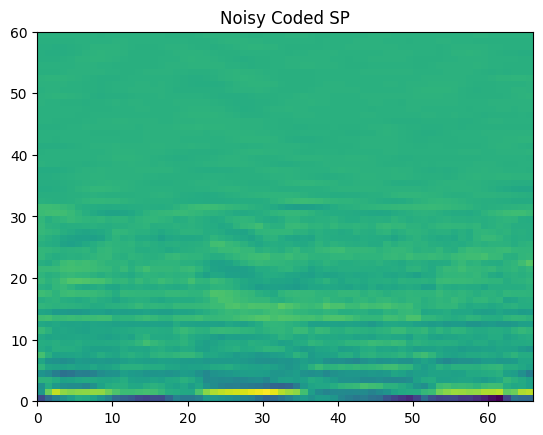

In [10]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib.colors import LogNorm
import torch

i = 0
for batch_idx, (onehot_input, mfcc_input, target, _) in enumerate(tqdm(val_VAEDataloader)):
    if batch_idx == 0:
        i = mfcc_input
    elif batch_idx % 4096 == 0:
        i = torch.cat((i, mfcc_input), 2)

print(i.size())
plt.pcolormesh(i.squeeze().detach().cpu().numpy())
plt.title("Noisy Coded SP")
plt.show()

In [3]:
import IPython
import torchaudio
print(generated_audio.size())
transform = torchaudio.transforms.MuLawDecoding(quantization_channels=256)
generated_audio_proc = generated_audio
decoded = transform(generated_audio_proc)
IPython.display.display(IPython.display.Audio(decoded.squeeze().detach().cpu().numpy(), rate = 16000))

torch.Size([1, 12288])


torch.Size([1, 4096])


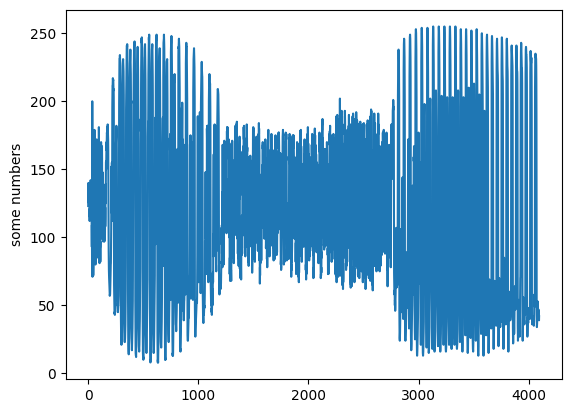

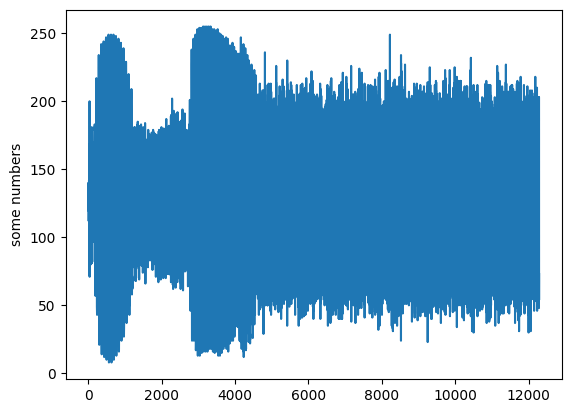

In [4]:
onehot, mfcc, target, _ = next(iter(val_VAEDataloader))

import matplotlib.pyplot as plt
print(onehot[:, -4096:].size())
plt.plot(torch.squeeze(onehot[:, -4096:]).numpy())
plt.ylabel('some numbers')
plt.show()

plt.plot(torch.squeeze(generated_audio_proc.cpu()).numpy())
plt.ylabel('some numbers')
plt.show()